# Compare 2 drones

Each drone has an  OAK D light.
One is 380cm diagonal frame the other is 230cm.

In [1]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
import scipy.stats as stats
from ardupilot_log_reader.reader import Ardupilot


In [2]:
HOME = os.getenv("HOME")

SAVE_FIG = True
FIG_FMT = 'svg'
NOISE_PARAM_UNIT = 'rad'
ANGLE_UNIT_FOR_NOISE = 'rad' # or 'deg'
VELOCITY_UNIT_FOR_NOISE = 'm/s' # or e.g. 'cm/s'
ACCELERATION_UNIT_FOR_NOISE = 'm/s²' # or 'ug'
ACCELERATION_UNIT = 'm/s²' # or 'g'
# printings and formatting, conversion factors
# m/s² to μg
MS2_TO_MICROG = 1e6 / 9.81
PRECI= 2
TYPE = "e" # e: exponential notation
# NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
NB_SAMPLE = 24000 # 24000 is 2mn of data at 200Hz

DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram
LOAD_SAMPLE = 'all'
# LOAD_SAMPLE = 'start'

In [58]:
PATH2FILE = HOME + '/Data/Drones/IMU/'
# PATH2FILE = HOME + '/Data/Drones/IMU/380_frame/31052024/'

# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_90mn_SR200_Static_yUp' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_30mn_SR200_motorOn_29042024' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_60mn_SR200_motorOn_03052024' 
# MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_2mn_SR200_CartRolling_yUp'
MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_2mn_SR200_FlightManual_yUp'
# old name: 'OAKLight_BMI270_90mn_gyroSR250_accSR250_yUp'
CSV_FILENAME = PATH2FILE + MEAS_FILENAME_NO_EXT + '.csv' 
# some string manip
split_btwn__ = MEAS_FILENAME_NO_EXT.split('_')
CAM_NAME = split_btwn__[0]
IMU_NAME = split_btwn__[1]
MEAS_DURATION = split_btwn__[3]
IMU_ORIENTATION = split_btwn__[-1]
TEST_CONFIG = split_btwn__[-2] # how the test was conducted (in flight, static....)
FIG_FILENAME_BASE = IMU_NAME + '_' + TEST_CONFIG

# get the sampling rate from file name
try:
    sr = MEAS_FILENAME_NO_EXT.split('SR')[1]
    sr = (float)(sr.split('_')[0])
    FS = sr
    print(f'got the sampling rate from filename, FS = {FS}')
except:    
    FS = 200 # Sample rate [Hz] # this is obtained from the measured data
    print(f'This is the sampling rate: FS = {FS}\n Make sure it is correct!')
fs_actual = FS
TS = 1.0 / FS


got the sampling rate from filename, FS = 200.0


In [59]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [60]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [61]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'Input array shape: {dataArr_shape}')
print(f'total number of samples in the whole array: {tot_nb_sample}')
print(f'number of samples to use for analysis: {len(acc_ts)}')

Input array shape: (24000, 8)
total number of samples in the whole array: 24000
number of samples to use for analysis: 24000


## 230mm frame, manual flight

In [62]:
print(accx.shape)

(24000,)


In [63]:
# some setups which can be convienient later on
acc_plot_label = ('accx','accy','accz')
gyr_plot_label = ('gyrx','gyry','gyrz')
acceleration_xyz = np.empty((0,3), float)
rotationrate_xyz = np.empty((0,3), float)
acceleration_xyz = np.column_stack((accx, accy,accz))
rotationrate_xyz = np.column_stack((gx, gy,gz))
# acceleration_xyz = np.append(acceleration_xyz, np.array([accx, accy,accz]).reshape(1,3), axis=0)
# rotationrate_xyz = np.append(rotationrate_xyz, np.array([gyrx, gyry,gyrz]).reshape(1,3), axis=0)

In [64]:
print(acceleration_xyz.shape)

(24000, 3)


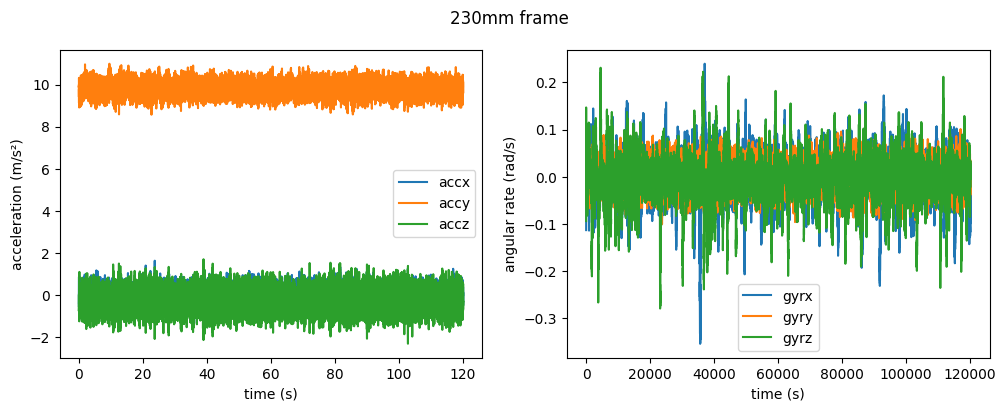

In [65]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
for i in range(3):
    ax[0].plot(ts/1000,acceleration_xyz[:,i],label = acc_plot_label[i])
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('acceleration (m/s²)')
    ax[0].legend()
    ax[1].plot(ts,rotationrate_xyz[:,i],label = gyr_plot_label[i])
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('angular rate (rad/s)')
    ax[1].legend()
fig.suptitle("230mm frame")
fig.savefig("230frame_acc_gyro_2mn.png")

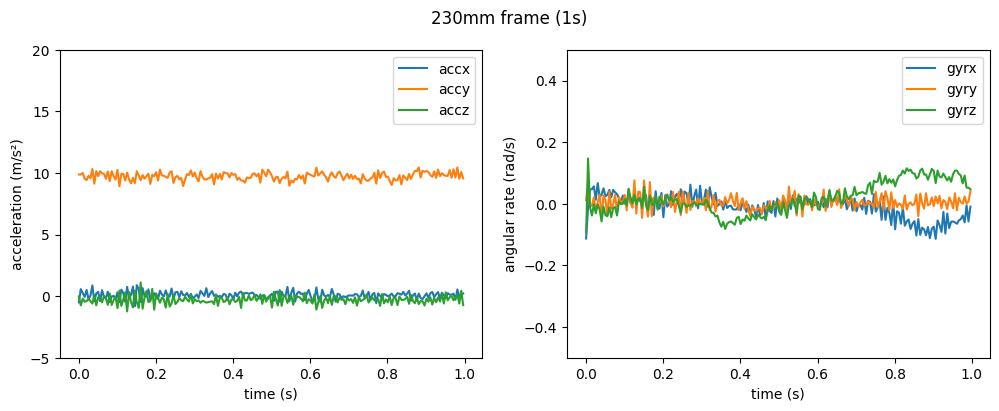

In [67]:
# zoom in
nbs = 200
fig,ax = plt.subplots(1,2,figsize=(12,4))
# ax[0].plot(ts[:nbs],acceleration_xyz[:nbs,1],label = acc_plot_label[1])
for i in range(3):
    ax[0].plot(ts[:nbs]/1000,acceleration_xyz[:nbs,i],label = acc_plot_label[i])
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('acceleration (m/s²)')
    ax[0].set_ylim(-5,20)
    ax[0].legend()
    ax[1].plot(ts[:nbs]/1000,rotationrate_xyz[:nbs,i],label = gyr_plot_label[i])
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('angular rate (rad/s)')
    ax[1].set_ylim(-0.5,0.5)
    ax[1].legend()
fig.suptitle("230mm frame (1s)")
fig.savefig("230frame_acc_gyro_2mn_1s.png")  

## 380mm frame, manual flight

In [68]:
PATH2FILE = HOME + '/Data/Drones/IMU/380_frame/31052024/'
MEAS_FILENAME_NO_EXT = 'OAKLight_BMI270_2mn_SR200_FlightManual'
CSV_FILENAME = PATH2FILE + MEAS_FILENAME_NO_EXT + '.csv' 
# some string manip
split_btwn__ = MEAS_FILENAME_NO_EXT.split('_')
CAM_NAME = split_btwn__[0]
IMU_NAME = split_btwn__[1]
MEAS_DURATION = split_btwn__[3]
IMU_ORIENTATION = split_btwn__[-1]
TEST_CONFIG = split_btwn__[-2] # how the test was conducted (in flight, static....)

# get the sampling rate from file name
try:
    sr = MEAS_FILENAME_NO_EXT.split('SR')[1]
    sr = (float)(sr.split('_')[0])
    FS = sr
    print(f'got the sampling rate from filename, FS = {FS}')
except:    
    FS = 200 # Sample rate [Hz] # this is obtained from the measured data
    print(f'This is the sampling rate: FS = {FS}\n Make sure it is correct!')

TS = 1.0 / FS


got the sampling rate from filename, FS = 200.0


In [69]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [70]:
# Separate into arrays and select a slice of the input data
if LOAD_SAMPLE == 'all':
    acc_ts = dataArr[:, 0]  # time stamp for acceleration, second
    accx = dataArr[:, 1]  # m/s²
    accy = dataArr[:, 2]
    accz = dataArr[:, 3]
    ts = dataArr[:, 4]  # time stamp, second
    gx = dataArr[:, 5]  # (rad/s)
    gy = dataArr[:, 6]
    gz = dataArr[:, 7]
elif LOAD_SAMPLE == 'start':
    acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
    accx = dataArr[:NB_SAMPLE, 1]  # m/s²
    accy = dataArr[:NB_SAMPLE, 2]
    accz = dataArr[:NB_SAMPLE, 3]
    ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
    gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
    gy = dataArr[:NB_SAMPLE, 6]
    gz = dataArr[:NB_SAMPLE, 7]
elif LOAD_SAMPLE == 'end':
    acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
    accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
    accy = dataArr[-NB_SAMPLE:, 2]
    accz = dataArr[-NB_SAMPLE:, 3]
    ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
    gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
    gy = dataArr[-NB_SAMPLE:, 6]
    gz = dataArr[-NB_SAMPLE:, 7]

In [71]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'Input array shape: {dataArr_shape}')
print(f'total number of samples in the whole array: {tot_nb_sample}')
print(f'number of samples to use for analysis: {len(acc_ts)}')

Input array shape: (24000, 8)
total number of samples in the whole array: 24000
number of samples to use for analysis: 24000


In [72]:
print(accx.shape)

(24000,)


In [73]:
# some setups which can be convienient later on
acc_plot_label = ('accx','accy','accz')
gyr_plot_label = ('gyrx','gyry','gyrz')
acceleration_xyz = np.empty((0,3), float)
rotationrate_xyz = np.empty((0,3), float)
acceleration_xyz = np.column_stack((accx, accy,accz))
rotationrate_xyz = np.column_stack((gx, gy,gz))
# acceleration_xyz = np.append(acceleration_xyz, np.array([accx, accy,accz]).reshape(1,3), axis=0)
# rotationrate_xyz = np.append(rotationrate_xyz, np.array([gyrx, gyry,gyrz]).reshape(1,3), axis=0)

In [74]:
print(acceleration_xyz.shape)

(24000, 3)


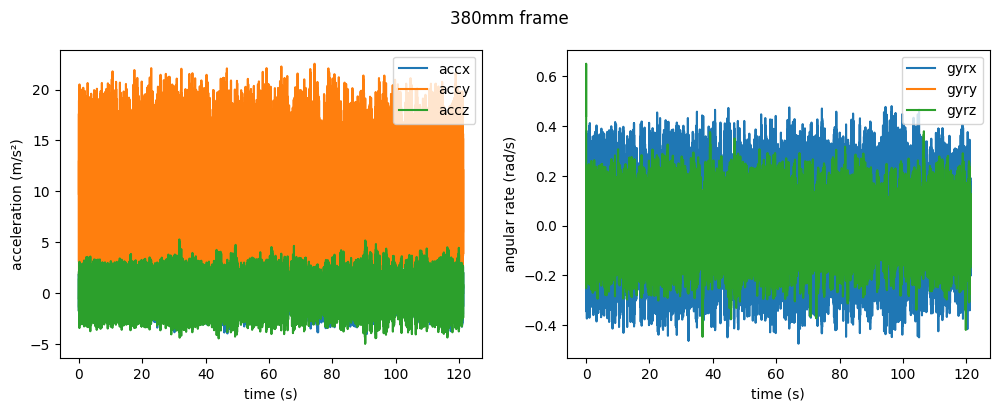

In [75]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
for i in range(3):
    ax[0].plot(ts/1000,acceleration_xyz[:,i],label = acc_plot_label[i])
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('acceleration (m/s²)')
    ax[0].legend()
    ax[1].plot(ts/1000,rotationrate_xyz[:,i],label = gyr_plot_label[i])
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('angular rate (rad/s)')
    ax[1].legend()
fig.suptitle("380mm frame")
fig.savefig("380frame_acc_gyro_2mn.png")

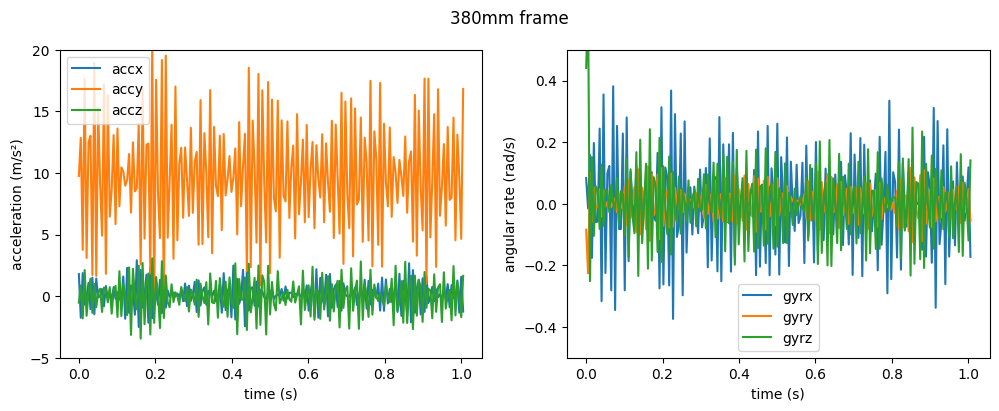

In [76]:
# zoom in
nbs = 200
fig,ax = plt.subplots(1,2,figsize=(12,4))
# ax[0].plot(ts[:nbs],acceleration_xyz[:nbs,1],label = acc_plot_label[1])
for i in range(3):
    ax[0].plot(ts[:nbs]/1000,acceleration_xyz[:nbs,i],label = acc_plot_label[i])
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('acceleration (m/s²)')
    ax[0].set_ylim(-5,20)
    ax[0].legend()
    ax[1].plot(ts[:nbs]/1000,rotationrate_xyz[:nbs,i],label = gyr_plot_label[i])
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('angular rate (rad/s)')
    ax[1].set_ylim(-0.5,0.5)
    ax[1].legend()
fig.suptitle("380mm frame")
fig.savefig("380frame_acc_gyro_2mn_1s.png")    

Noise densities (N, acc_n / gyro_n) from PSD for OAKLight_BMI270_2mn_SR200_FlightManual
AX Noise Density: 7.28e-02 m/s²/sqrt(Hz)
AY Noise Density: 2.47e-01 m/s²/sqrt(Hz)
AZ Noise Density: 9.52e-02 m/s²/sqrt(Hz)
GX Noise Density: 9.05e-03 rad/s/sqrt(Hz)
GY Noise Density: 2.97e-03 rad/s/sqrt(Hz)
GZ Noise Density: 5.94e-03 rad/s/sqrt(Hz)
figure saved to Acc_PSD_Welch_BMI270_FlightManual.svg
figure saved to Gyro_PSD_Welch_BMI270_FlightManual.svg


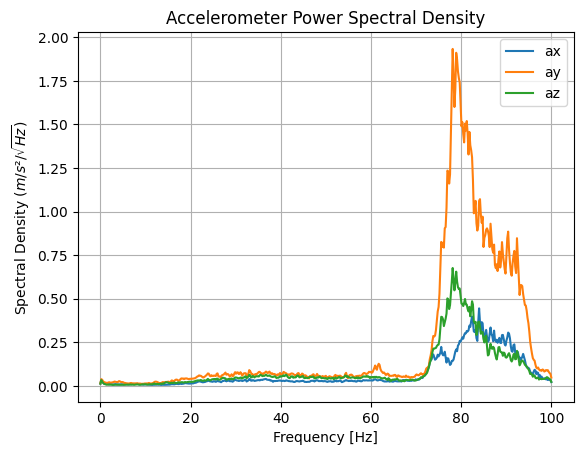

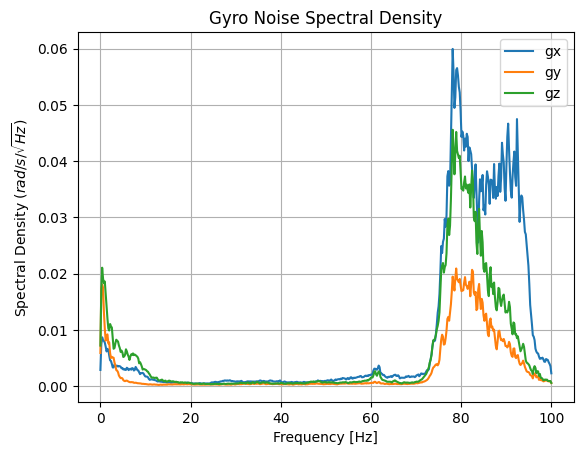

In [77]:

if ACCELERATION_UNIT_FOR_NOISE == 'm/s²':
    scale_acc_psd = 1
    acc_noise_density_unit = 'm/s²/sqrt(Hz)'
    acc_ylabel = r'Spectral Density ($m/s²  / \sqrt{Hz}$)'
elif ACCELERATION_UNIT_FOR_NOISE == 'ug':
    scale_acc_psd = MS2_TO_MICROG
    acc_noise_density_unit = r'Spectral Density  $\mu g  / \sqrt{Hz}$'# 'ug/sqrt(Hz)'
    acc_ylabel = r'Spectral Density  $\mu g  / \sqrt{Hz}$'
if ANGLE_UNIT_FOR_NOISE == 'rad':
    scale_gyr_psd = 1
    gyr_noise_density_unit = 'rad/s/sqrt(Hz)'
    gyr_ylabel = r'Spectral Density ($rad/s  / \sqrt{Hz}$)'
elif ANGLE_UNIT_FOR_NOISE == 'deg':
    scale_gyr_psd = RAD_2_DEG
    gyr_noise_density_unit = '°/s/sqrt(Hz)'
    gyr_ylabel = r'Spectral Density ($°/s  / \sqrt{Hz}$)'
print(f'Noise densities (N, acc_n / gyro_n) from PSD for {MEAS_FILENAME_NO_EXT}')

# Compute PSD via Welch algorithm
freqax, psdax = signal.welch(accx, fs_actual, nperseg=1024, scaling='density')  # ax
freqay, psday = signal.welch(accy, fs_actual, nperseg=1024, scaling='density')  # ay
freqaz, psdaz = signal.welch(accz, fs_actual, nperseg=1024, scaling='density')  # az

freqgx, psdgx = signal.welch(gx, fs_actual, nperseg=1024, scaling='density')  # gx
freqgy, psdgy = signal.welch(gy, fs_actual, nperseg=1024, scaling='density')  # gy
freqgz, psdgz = signal.welch(gz, fs_actual, nperseg=1024, scaling='density')  # gz

# scale depending on target units
psdax = np.sqrt(psdax) * scale_acc_psd
psday = np.sqrt(psday) * scale_acc_psd
psdaz = np.sqrt(psdaz) * scale_acc_psd

psdgx = np.sqrt(psdgx) * scale_gyr_psd
psdgy = np.sqrt(psdgy) * scale_gyr_psd
psdgz = np.sqrt(psdgz) * scale_gyr_psd

# Compute noise spectral densities
ndax = np.mean(psdax)
nday = np.mean(psday)
ndaz = np.mean(psdaz)
print(f'AX Noise Density: {ndax:.{PRECI}{TYPE}} {acc_noise_density_unit}')
print(f'AY Noise Density: {nday:.{PRECI}{TYPE}} {acc_noise_density_unit}')
print(f'AZ Noise Density: {ndaz:.{PRECI}{TYPE}} {acc_noise_density_unit}')
# print('AY Noise Density: %f ug/sqrt(Hz)' % (nday))
# print('AZ Noise Density: %f ug/sqrt(Hz)' % (ndaz))

ndgx = np.mean(psdgx)
ndgy = np.mean(psdgy)
ndgz = np.mean(psdgz)
print(f'GX Noise Density: {ndgx:.{PRECI}{TYPE}} {gyr_noise_density_unit}')
print(f'GY Noise Density: {ndgy:.{PRECI}{TYPE}} {gyr_noise_density_unit}')
print(f'GZ Noise Density: {ndgz:.{PRECI}{TYPE}} {gyr_noise_density_unit}')

# print('GX Noise Density: %f dps/sqrt(Hz)' % (ndgx))
# print('GY Noise Density: %f dps/sqrt(Hz)' % (ndgy))
# print('GZ Noise Density: %f dps/sqrt(Hz)' % (ndgz))


# Plot accel. data
plt.figure()
plt.plot(freqax, psdax, label='ax')
plt.plot(freqay, psday, label='ay')
plt.plot(freqaz, psdaz, label='az')
plt.title('Accelerometer Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel(acc_ylabel)
# plt.ylabel(r'Spectral Density  $\mu g  / \sqrt{Hz}$')
plt.legend()
plt.grid()
if SAVE_FIG:
    figname = f'Acc_PSD_Welch_{FIG_FILENAME_BASE}.{FIG_FMT}'
    plt.savefig(figname)
    print(f'figure saved to {figname}')

# Plot gyro data
plt.figure()
plt.plot(freqgx, psdgx, label='gx')
plt.plot(freqgy, psdgy, label='gy')
plt.plot(freqgz, psdgz, label='gz')
plt.title('Gyro Noise Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel(gyr_ylabel)

# plt.ylabel(r'Spectral Density  $dps  / \sqrt{Hz}$')
plt.legend()
plt.grid()
if SAVE_FIG:
    figname = f'Gyro_PSD_Welch_{FIG_FILENAME_BASE}.{FIG_FMT}'
    plt.savefig(figname)
    print(f'figure saved to {figname}')
plt.show()